<a href="https://colab.research.google.com/github/nmadruga/Sailboat-detection/blob/main/COMP383_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%env ROBOFLOW_KEY_SAILBOATS=xxx
%env ROBOFLOW_KEY_LARGE_DATASET=yyy

env: ROBOFLOW_KEY_SAILBOATS=KdPDkLaaru
env: ROBOFLOW_KEY_LARGE_DATASET=nl2j4a3I01


In [2]:
import os, io
import torch
import torchvision
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import zipfile

!pip install torch torchvision

np.random.seed(42)

TRAIN = True
EPOCHS = 15 # Number of epochs to train for.

def download_file(url, save_name):
    if save_name == './' or not os.path.exists(save_name):
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(save_name)
        print(f'Finished extractin zip file: {z}')
    else:
        print('Folder already present, skipping download...')

if not os.path.exists('train'):
  url = 'https://app.roboflow.com/ds/PmEYGze19l?key='+os.environ['ROBOFLOW_KEY_LARGE_DATASET']
  download_file(url, './')
else: 
  print('Dataset already present, skipping download...')

  # dirs = ['train', 'valid', 'test']

  # for i, dir_name in enumerate(dirs):
  #     all_image_names = sorted(os.listdir(f"dataset/{dir_name}/images/"))
  #     for j, image_name in enumerate(all_image_names):
  #         if (j % 2) == 0:
  #             file_name = image_name.split('.jpg')[0]
  #             os.remove(f"dataset/{dir_name}/images/{image_name}")
  #             os.remove(f"dataset/{dir_name}/labels/{file_name}.txt")

def download_file(url, save_name):
  url = url
  if not os.path.exists(save_name):
      file = requests.get(url)
      open(save_name, 'wb').write(file.content)
  else: 
      print('File already present, skipping download...')

class_names = ['Boat','kayak','motorboat','sailboat']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
  all_training_images = glob.glob(image_paths)
  all_training_labels = glob.glob(label_paths)
  all_training_images.sort()
  all_training_labels.sort()
  
  num_images = len(all_training_images)
  
  plt.figure(figsize=(15, 12))
  for i in range(num_samples):
      j = random.randint(0,num_images-1)
      image = cv2.imread(all_training_images[j])
      with open(all_training_labels[j], 'r') as f:
        print(f'{j} labels:', all_training_labels[j])
        bboxes = []
        labels = []
        label_lines = f.readlines()
        for label_line in label_lines:
            label = label_line[0]
            bbox_string = label_line[2:]
            x_c, y_c, w, h = bbox_string.split(' ')
            x_c = float(x_c)
            y_c = float(y_c)
            w = float(w)
            h = float(h)
            bboxes.append([x_c, y_c, w, h])
            labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
  plt.subplots_adjust(wspace=0)
  plt.tight_layout()
  plt.show()

# ## Run different models and check accuracy of detection in num_samples
# def check_models(model_paths, num_samples):
#  all_testing_images = glob.glob('test/images/*')

#  # Select a sample set to test detect images
#  sample_images = random.choices(all_testing_images, k=num_samples)

#  images = []
#  for image_path in sample_images:
#     image = torchvision.io.read_image(image_path).float() / 255.0
#     images.append(image.unsqueeze(0))

#  # Compare the models
#  for model_name, model_path in model_paths.items():
#     # Load the model
#     model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True)
#     model.eval()

#     with torch.no_grad():
#         outputs = model(image)

#     # Print the results
#     print(f'Model: {model_name} - Image: {image}')
#     results = outputs.pandas().xyxy[0]
#     print(results)
#     print()

def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Finished extractin zip file: <zipfile.ZipFile file=<_io.BytesIO object at 0x7fe160fd42c0> mode='r'>


In [3]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

%cd yolov5/
!pwd

!pip install -r requirements.txt

%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 15965, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 15965 (delta 82), reused 104 (delta 67), pack-reused 15831
Receiving objects: 100% (15965/15965), 14.54 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (10956/10956), done.
/content/yolov5
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.1/593.1 kB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
/content


1260 labels: train/labels/000000288340_png.rf.f9845b2af2b54d79627f46839c1a2878.txt
2333 labels: train/labels/000000494236_png.rf.0eea8c103cd8e89b10c81b7cde419634.txt
851 labels: train/labels/000000210149_png.rf.07bbbbe06daf180a439d749505ac16bf.txt
1341 labels: train/labels/000000304314_png.rf.8842b15fba179f3a74f316cd1909de84.txt


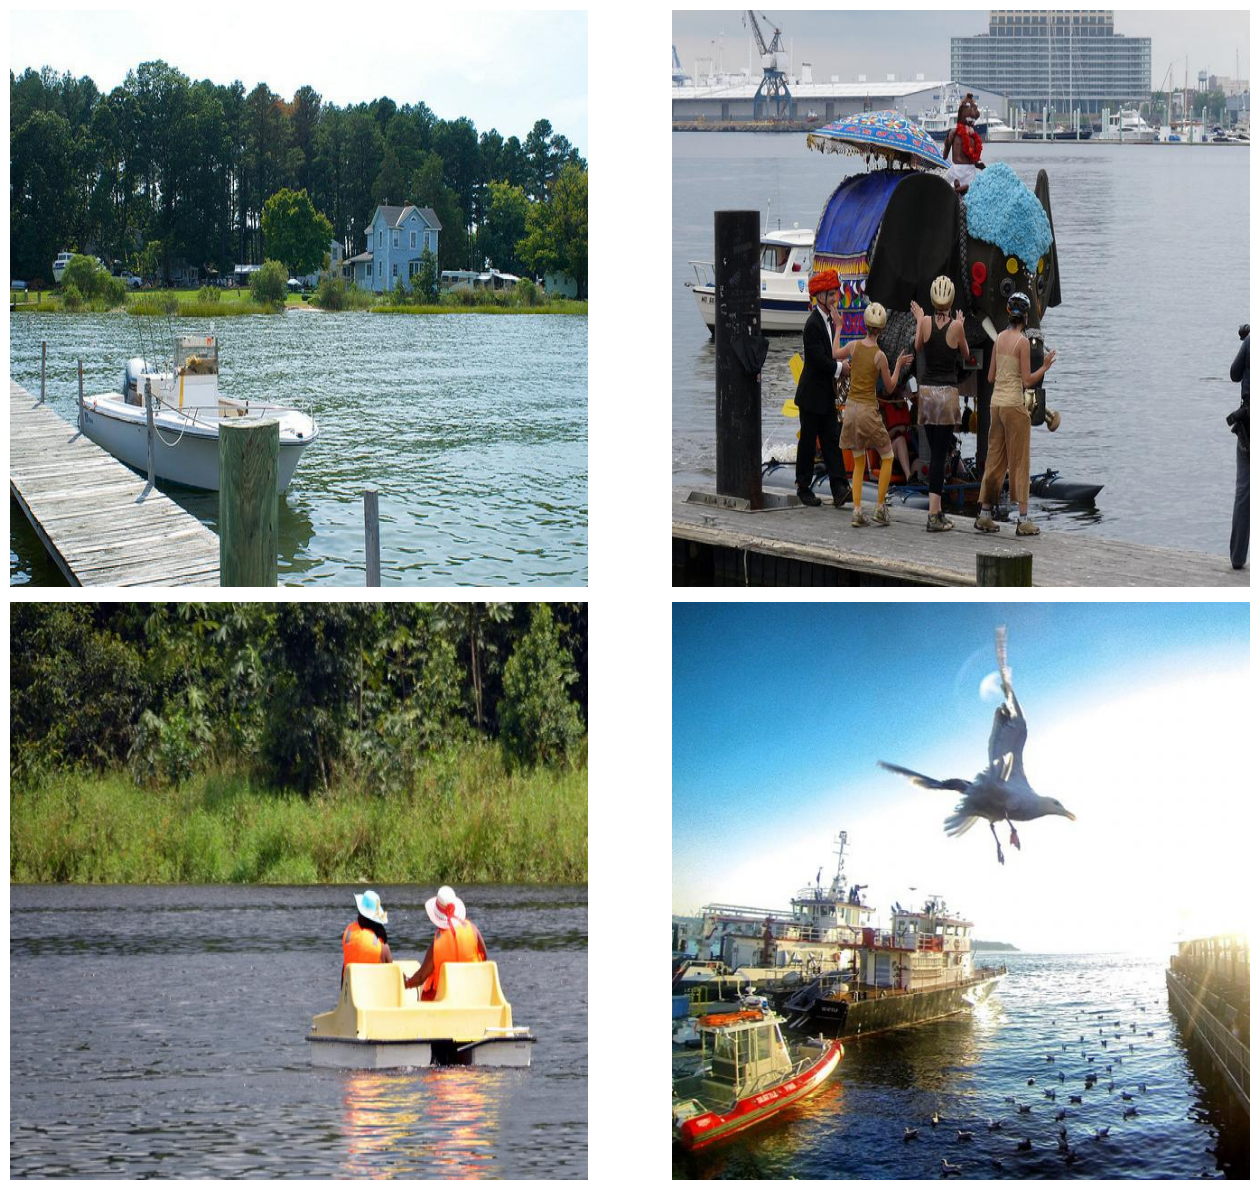

In [4]:
# Visualize a few training images.
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

# # Define the YOLOv5 models to compare
# check_models(
#     model_paths={
#     'yolov5s': 'yolov5s.pt',
#     'yolov5m': 'yolov5m.pt',
#     'yolov5l': 'yolov5l.pt',
#     'yolov5x': 'yolov5x.pt'
#     },
#     num_samples=10)

In [ ]:
monitor_tensorboard()

RES_DIR = set_res_dir()
if TRAIN:
  %cd yolov5

  !python train.py --data ../data.yaml --weights yolov5s.pt \
  --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} --single-cls

  # !python train.py --data ../data.yaml --weights yolov5m.pt \
  # --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} --single-cls

  # !python train.py --data ../data.yaml --weights yolov5l.pt \
  # --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} --single-cls

  # !python train.py --data ../data.yaml --weights yolov5x.pt \
  # --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} --single-cls

%cd ..

<IPython.core.display.Javascript object>

Current number of result directories: 0
results_1
/content/yolov5
train: weights=yolov5s.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=True, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-175-g5f11555 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, io

In [ ]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
%cd yolov5

show_valid_results(RES_DIR)

url = 'https://app.roboflow.com/ds/1fBU7vhVon?key'+os.environ['ROBOFLOW_KEY_SAILBOATS']
!curl -L url > inference_data.zip
if not os.path.exists('inference_images'):
    !unzip -q "inference_data"
else:
    print('Dataset already present')

# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images/test')

visualize(IMAGE_INFER_DIR)

monitor_tensorboard()

RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

%cd ..